## Graph Neural Network for Molecular Interaction Prediction
### SAGEConv

This Jupyter Notebook outlines the process for training a Graph Neural Network (GNN) model to predict molecular interactions using the SAGEConv architecture. The goal of this project is to leverage the inherent graph structure of molecules for effective prediction of binding to RNA, a crucial factor in drug discovery and biological research.

Each run of this notebook represents a distinct experiment with specified hyperparameters and configurations. Results and models from each run are saved separately for comparative analysis to ensure the reproducibility and statistical significance of our findings.

### Notebook Details:

- **Objective**: Predict molecular interactions with RNA using GNN.
- **Model Architecture**: SAGEConv from the Deep Graph Library (DGL).
- **Data Source**: Preprocessed molecular datasets.
- **Run Number**: This notebook facilitates multiple runs. Specific details for each run, including the random state and run number, are set at the beginning to ensure reproducibility.

Before executing the notebook, please adjust the `RANDOM_STATE` and `RUN_NUMBER` variables at the top of the notebook to reflect the specific experiment being conducted. This setup ensures each run's outputs are unique and traceable.


In [1]:
"""
This script implements a Graph Neural Network (GNN) using the SAGEConv architecture
for the purpose of predicting molecular interactions. The implementation leverages
the Deep Graph Library (DGL) for constructing and manipulating graphs, as well as
Optuna for hyperparameter optimization. The model includes features such as dropout,
early stopping, and gradient scaling for improved training stability and performance.
"""


'\nThis script implements a Graph Neural Network (GNN) using the SAGEConv architecture\nfor the purpose of predicting molecular interactions. The implementation leverages\nthe Deep Graph Library (DGL) for constructing and manipulating graphs, as well as\nOptuna for hyperparameter optimization. The model includes features such as dropout,\nearly stopping, and gradient scaling for improved training stability and performance.\n'

In [2]:
# Set the random seed and run number at the top for reproducibility and to 
# differentiate runs
RANDOM_STATE = 555  # Change for each run if needed
RUN_NUMBER = 7  # Change for each run

import numpy as np
import torch
import dgl

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
dgl.seed(RANDOM_STATE)


## Import Necessary Libraries

In [3]:
import os
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import dgl
from dgl.nn import SAGEConv, GlobalAttentionPooling
from dgl.dataloading import GraphDataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import optuna
from optuna.pruners import MedianPruner
from torch.cuda.amp import GradScaler, autocast


## The SAGEConv Graph Neural Network Model



In [4]:
class GraphClsSAGE(nn.Module):
    """
    A Graph Neural Network (GNN) model using the GraphSAGE architecture for 
    graph classification.
    
    Parameters
    ----------
    in_feats : int
        The number of input features.
    hidden_dim : int
        The number of output features (hidden dimensions of each layer).
    aggregator_type : str
        The aggregator type ('mean', 'gcn', 'pool', 'lstm').
    dropout_rate : float
        The dropout rate for the input features.
    num_cls : int
        The number of classes for classification.
    """
    def __init__(self, in_feats, hidden_dim, aggregator_type, dropout_rate, num_cls):
        super(GraphClsSAGE, self).__init__()
        # The first SAGE layer
        self.sage_1 = SAGEConv(
            in_feats=in_feats,
            out_feats=hidden_dim,
            aggregator_type=aggregator_type,
            feat_drop=dropout_rate,
        )
        
        # The second SAGE layer
        self.sage_2 = SAGEConv(
            in_feats=hidden_dim,
            out_feats=hidden_dim,
            aggregator_type=aggregator_type,
            feat_drop=dropout_rate,
        )
        
        # Global attention pooling layer to aggregate node features to a graph-level feature
        self.pooling = GlobalAttentionPooling(nn.Linear(hidden_dim, 1))
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, num_cls)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, graph, feat):
        # Apply dropout to input features
        feat = self.dropout(feat)
        
        # Apply the first SAGE layer and then activation and dropout
        h = self.sage_1(graph, feat)
        h = F.relu(h)  # Apply activation here
        h = self.dropout(h)  # Apply dropout after activation
        
        # Apply the second SAGE layer and then activation and dropout
        h = self.sage_2(graph, h)
        h = F.relu(h)  # Apply activation here
        h = self.dropout(h)  # Apply dropout after activation
        
        # Aggregate node features to graph-level features using global attention pooling
        hg = self.pooling(graph, h).squeeze()
        
        # Classify based on the graph-level representation
        return self.fc(hg)

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()


## Early Stopping Mechanism



In [5]:
class EarlyStopping:
    """Early stops the training if neither validation loss nor validation 
    accuracy improves after their respective patience levels.
    
    Parameters
    ----------
    patience_loss : int
        How long to wait after last time validation loss improved.
    patience_accuracy : int
        How long to wait after last time validation accuracy improved.
    verbose : bool
        If True, prints a message for each validation metric improvement.
    delta_loss : float
        Minimum change in the validation loss to qualify as an improvement.
    delta_accuracy : float
        Minimum change in the validation accuracy to qualify as an improvement.
    path : str
        The file path where the model will be saved.
    print_freq : int
        The frequency at which to print messages during training.
    """

    def __init__(
            self,
            patience_loss=10,
            patience_accuracy=10,
            verbose=True,
            delta_loss=0.001,
            delta_accuracy=0.001,
            path='checkpoint.pt',
            print_freq=5):
        self.patience_loss = patience_loss
        self.patience_accuracy = patience_accuracy
        self.verbose = verbose
        self.counter_loss = 0
        self.counter_accuracy = 0
        self.best_loss = np.Inf
        self.best_accuracy = 0
        self.early_stop = False
        self.delta_loss = delta_loss
        self.delta_accuracy = delta_accuracy
        self.path = path
        self.best_epoch = 0
        self.print_freq = print_freq
        
    def __call__(self, val_loss, val_accuracy, model, epoch):
        improved_loss = False
        improved_accuracy = False
        
        # Check improvement for loss
        if val_loss < self.best_loss - self.delta_loss:
            self.best_loss = val_loss
            self.counter_loss = 0
            improved_loss = True
        else:
            self.counter_loss += 1
        
        # Check improvement for accuracy
        if val_accuracy > self.best_accuracy + self.delta_accuracy:
            self.best_accuracy = val_accuracy
            self.counter_accuracy = 0
            improved_accuracy = True
        else:
            self.counter_accuracy += 1
        
        # Save checkpoint if either metric improved
        if improved_loss or improved_accuracy:
            self.save_checkpoint(val_loss, val_accuracy, model)
            self.best_epoch = epoch
        
        if self.verbose and (improved_loss or improved_accuracy):
            print(f"Improvement at epoch {epoch}: Loss = {val_loss}, "
                f"Accuracy = {val_accuracy}")
        
        # Determine if early stopping is triggered
        if self.counter_loss >= self.patience_loss and \
            self.counter_accuracy >= self.patience_accuracy:
            self.early_stop = True
            if self.verbose:
                print("Early stopping triggered")
                
    def save_checkpoint(self, val_loss, val_accuracy, model):
        # Implement saving logic based on your requirements
        torch.save(model.state_dict(), self.path)
        if self.verbose:
            print(f"Checkpoint saved: Loss = {val_loss}, "
                  f"Accuracy = {val_accuracy}")



## The Collate Function for DataLoader



In [6]:
def collate(samples):
    """
    Function to collate samples into a batch for the GraphDataLoader.
    
    Parameters
    ----------
    samples : list
        A list of tuples of the form (graph, label).
    """
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    labels = torch.tensor(labels, dtype=torch.long)
    return batched_graph, labels


## Training and Evaluation Pipeline


In [7]:
class TrainingPipeline:
    def __init__(self, device):
        self.device = device

    def train_and_evaluate(
            self,
            model,
            train_loader,
            val_loader,
            optimizer,
            criterion,
            early_stopping,
            num_epochs,
            plot_curves=False,
            accumulation_steps=2):
        train_losses, val_losses = [], []
        scaler = GradScaler()  # Initialize the gradient scaler

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            optimizer.zero_grad()  # Initialize gradients to zero

            for batch_idx, (batched_graph, labels) in enumerate(train_loader):
                batched_graph, labels = batched_graph.to(
                    self.device), labels.to(self.device)

                with autocast():  # Enable automatic mixed precision
                    logits = model(
                        batched_graph, batched_graph.ndata['h'].float())
                    loss = criterion(logits, labels) / \
                        accumulation_steps  # Scale loss

                # Scale the loss and call backward to propagate gradients
                scaler.scale(loss).backward()
                # Correct scaling for logging purposes
                train_loss += loss.item() * accumulation_steps

                if (batch_idx + 1) % accumulation_steps == 0 or \
                        batch_idx == len(train_loader) - 1:
                    # Perform optimizer step using scaled gradients
                    scaler.step(optimizer)
                    scaler.update()  # Update the scaler for the next iteration
                    optimizer.zero_grad()  # Initialize gradients to zero

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            val_loss = 0.0
            val_accuracy = 0.0
            val_correct = 0
            total = 0
            if val_loader is not None:
                model.eval()
                with torch.no_grad():
                    val_correct = 0
                    total = 0
                    for batched_graph, labels in val_loader:
                        batched_graph, labels = batched_graph.to(
                            self.device), labels.to(self.device)
                        with autocast():  # Enable automatic mixed precision
                            logits = model(
                                batched_graph, batched_graph.ndata['h'].float()
                            )
                            loss = criterion(logits, labels)
                        val_loss += loss.item()
                        _, predicted = torch.max(logits.data, 1)
                        total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()

                    val_loss /= len(val_loader)
                    val_losses.append(val_loss)
                    val_accuracy = val_correct / total
                    
                    # here will be early stopping
                    if early_stopping:
                        early_stopping(val_loss, val_accuracy, model, epoch + 1)
                        if early_stopping.early_stop:
                            print(
                                f"Early stopping triggered"
                                f"at epoch {epoch + 1}")
                            break

                if (epoch + 1) % 5 == 0 or epoch == 0:
                    print(
                        f'Epoch {epoch + 1}/{num_epochs} - '
                        f'Train Loss: {train_loss:.4f}, '
                        f'Val Loss: {val_loss:.4f} '
                        f'| Val accuracy: {100 * val_accuracy:.2f}%')

        if plot_curves and val_loader is not None:
            self.plot_loss_curves(train_losses, val_losses)

    @staticmethod
    def plot_loss_curves(train_losses, val_losses):
        sns.set(style="whitegrid")
        plt.figure(figsize=(10, 6))
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss of SAGEConv')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f'loss_curves_{RUN_NUMBER}.png', dpi=300)
        plt.show()

    def evaluate_on_test(self, model, test_loader, criterion, run_id):
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batched_graph, labels in test_loader:
                batched_graph, labels = batched_graph.to(self.device), labels.to(self.device)
                logits = model(batched_graph, batched_graph.ndata['h'].float())
                loss = criterion(logits, labels)
                test_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss /= len(test_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        roc_auc = roc_auc_score(all_labels, all_preds)

        # Calculate and save confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.savefig(f'confusion_matrix_{run_id}.png', dpi=300)

        # Append results to CSV including added metrics
        results_df = pd.DataFrame({
            'Run ID': [run_id],
            'Test Loss': [test_loss],
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1],
            'ROC-AUC': [roc_auc]
        })
        results_df.to_csv('test_results_SageConv.csv', mode='a', index=False, 
                        header=not os.path.exists('test_results_SageConv.csv'))

        print(f"Test Loss: {test_loss}")
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, ROC-AUC: {roc_auc}")


## Hyperparameter Optimization Using Optuna



In [8]:
class HyperparameterOptimizer:
    def __init__(
            self,
            device,
            subset_train_graphs,
            subset_train_labels,
            subset_val_graphs,
            subset_val_labels,
            num_trials,
            num_epochs):
        self.device = device
        self.subset_train_graphs = subset_train_graphs
        self.subset_train_labels = subset_train_labels
        self.subset_val_graphs = subset_val_graphs
        self.subset_val_labels = subset_val_labels
        self.num_trials = num_trials
        self.num_epochs = num_epochs

    def objective(self, trial):
        # Adjusting the hyperparameters for GraphSAGE model
        in_feats = 74  # Assuming this is fixed for your input features
        hidden_dim = trial.suggest_int('hidden_dim', 16, 256)
        aggregator_type = trial.suggest_categorical('aggregator_type', ['mean', 'gcn', 'pool', 'lstm'])
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
        lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
        batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])

        # Create the GraphSAGE model, optimizer, and loaders
        model = GraphClsSAGE(
            in_feats=in_feats,
            hidden_dim=hidden_dim,
            aggregator_type=aggregator_type,
            dropout_rate=dropout_rate,
            num_cls=2,  # Assuming binary classification
        ).to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        train_loader = GraphDataLoader(
            list(zip(self.subset_train_graphs, self.subset_train_labels)),
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate,
            num_workers=8)
        val_loader = GraphDataLoader(
            list(zip(self.subset_val_graphs, self.subset_val_labels)),
            batch_size=batch_size,
            shuffle=False,
            collate_fn=collate,
            num_workers=8)

        # Training loop with pruning
        model.train()
        for epoch in range(self.num_epochs):
            model.train()  # Ensure the model is in training mode
            for batched_graph, labels in train_loader:
                batched_graph, labels = batched_graph.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                logits = model(batched_graph, batched_graph.ndata['h'].float())
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

            model.eval()  # Switch to evaluation mode for validation
            val_loss = 0.0
            with torch.no_grad():
                for batched_graph, labels in val_loader:
                    batched_graph, labels = batched_graph.to(self.device), labels.to(self.device)
                    logits = model(batched_graph, batched_graph.ndata['h'].float())
                    loss = criterion(logits, labels)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            trial.report(val_loss, epoch)

            if trial.should_prune():
                raise optuna.TrialPruned()

        return val_loss

    def optimize(self):
        """Run the hyperparameter optimization."""
        study = optuna.create_study(direction='minimize', pruner=MedianPruner())
        study.optimize(self.objective, n_trials=self.num_trials)

        best_hyperparams = study.best_trial.params
        with open(f'sage_best_hyperparams_run_{RUN_NUMBER}.json', 'w') as f:
            json.dump(best_hyperparams, f)
        print(f"Best hyperparameters are {best_hyperparams}.")
        print("Best hyperparameters saved.")


## Main Training Loop



In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
# Load data and prepare for training
graphs, labels_dict = dgl.load_graphs("../../../data_mvi/data_for_ml/dataset_set2/model3_binders_nonbinders/graphs/graphs.bin")

# Directly extract labels tensor from labels_dict
labels_tensor = labels_dict['labels']
labels_tensor = labels_tensor.squeeze()

# Convert tensor to numpy array for compatibility with sklearn
labels_numpy = labels_tensor.numpy()

# Split dataset train, test
train_indices, test_indices, train_labels, test_labels = train_test_split(
    range(labels_dict['labels'].size(0)), labels_numpy, test_size=0.2, stratify=labels_numpy,
    random_state=RANDOM_STATE)

# Split dataset train, validation
train_indices, val_indices, train_labels, val_labels = train_test_split(
    train_indices, train_labels, test_size=0.2, stratify=train_labels,
    random_state=RANDOM_STATE)

# Placeholder for data loading. Replace this with your actual data loading
# code.
train_graphs = [graphs[i] for i in train_indices]
test_graphs = [graphs[i] for i in test_indices]
val_graphs = [graphs[i] for i in val_indices]

subset_train_indices = np.random.choice(
    len(train_graphs), size=int(len(train_graphs) * 1), replace=False)
subset_train_graphs = [train_graphs[i] for i in subset_train_indices]
subset_train_labels = train_labels[subset_train_indices]

subset_val_indices = np.random.choice(
    len(val_graphs), size=int(len(val_graphs) * 1), replace=False)
subset_val_graphs = [val_graphs[i] for i in subset_val_indices]
subset_val_labels = val_labels[subset_val_indices]

# Combine train and validation graphs and labels for retraining
combined_train_graphs = train_graphs + val_graphs
combined_train_labels = np.concatenate((train_labels, val_labels))

# annouce the start of the project
print("Starting the project...")
print("")

# annouce the start of the data loading
print("Starting data loading...")
print(
    f'Train: {len(train_graphs)}, Validation: {len(val_graphs)}, '
    f'Test: {len(test_graphs)}, \nSubset Train: {len(subset_train_graphs)}, '
    f'Subset Val: {len(subset_val_graphs)}'
)
print("")
print("Completed data loading.")
print("")
sys.stdout.flush()  # Force flushing of the buffer


Starting the project...

Starting data loading...
Train: 2528, Validation: 632, Test: 790, 
Subset Train: 2528, Subset Val: 632

Completed data loading.



## Perform Hyperparameter Optimization


In [11]:
# 1. Hyperparameter Optimization on a subset of the data
print("Starting hyperparameter optimization...")
sys.stdout.flush()
print("")

# Specify the number of trials and epochs for hyperparameter optimization
optimizer = HyperparameterOptimizer(
    device,
    subset_train_graphs,
    subset_train_labels,
    subset_val_graphs,
    subset_val_labels,
    num_trials=20,
    num_epochs=30)
optimizer.optimize()
print("Completed hyperparameter optimization.")
sys.stdout.flush()

print("")


Starting hyperparameter optimization...


[I 2024-04-28 16:09:38,692] A new study created in memory with name: no-name-268f7797-8647-46a9-addf-1c0c325a1201


[I 2024-04-28 16:10:06,789] Trial 0 finished with value: 0.7048423409461975 and parameters: {'hidden_dim': 118, 'aggregator_type': 'pool', 'dropout_rate': 0.2408884450032342, 'lr': 0.037668262967863686, 'batch_size': 128}. Best is trial 0 with value: 0.7048423409461975.


[I 2024-04-28 16:10:30,170] Trial 1 finished with value: 0.5816211899121603 and parameters: {'hidden_dim': 58, 'aggregator_type': 'pool', 'dropout_rate': 0.0967678191387657, 'lr': 0.012875412501883983, 'batch_size': 256}. Best is trial 1 with value: 0.5816211899121603.


[I 2024-04-28 16:10:55,196] Trial 2 finished with value: 0.6613875031471252 and parameters: {'hidden_dim': 91, 'aggregator_type': 'gcn', 'dropout_rate': 0.2304814360318047, 'lr': 0.00041036889885747916, 'batch_size': 256}. Best is trial 1 with value: 0.5816211899121603.


[I 2024-04-28 16:11:33,780] Trial 3 finished with value: 0.7004607498645783 and parameters: {'hidden_dim': 158, 'aggregator_type': 'gcn', 'dropout_rate': 0.3793225750616655, 'lr': 0.01733027997197803, 'batch_size': 64}. Best is trial 1 with value: 0.5816211899121603.


[I 2024-04-28 16:12:12,932] Trial 4 finished with value: 0.6205374717712402 and parameters: {'hidden_dim': 110, 'aggregator_type': 'mean', 'dropout_rate': 0.06179120239671926, 'lr': 0.05423974196462683, 'batch_size': 64}. Best is trial 1 with value: 0.5816211899121603.


[I 2024-04-28 16:12:13,877] Trial 5 pruned. 


[I 2024-04-28 16:12:51,816] Trial 6 finished with value: 0.6380472540855407 and parameters: {'hidden_dim': 104, 'aggregator_type': 'mean', 'dropout_rate': 0.25013374870771915, 'lr': 0.007158925305596846, 'batch_size': 64}. Best is trial 1 with value: 0.5816211899121603.


[I 2024-04-28 16:12:54,727] Trial 7 pruned. 


[I 2024-04-28 16:12:55,536] Trial 8 pruned. 


[I 2024-04-28 16:12:56,374] Trial 9 pruned. 


[I 2024-04-28 16:12:57,989] Trial 10 pruned. 


[I 2024-04-28 16:12:58,874] Trial 11 pruned. 


[I 2024-04-28 16:13:00,978] Trial 12 pruned. 


[I 2024-04-28 16:13:02,894] Trial 13 pruned. 


[I 2024-04-28 16:13:04,229] Trial 14 pruned. 


[I 2024-04-28 16:13:29,980] Trial 15 finished with value: 0.5933903853098551 and parameters: {'hidden_dim': 91, 'aggregator_type': 'mean', 'dropout_rate': 0.06375771290746605, 'lr': 0.01101198202515349, 'batch_size': 256}. Best is trial 1 with value: 0.5816211899121603.


[I 2024-04-28 16:13:30,930] Trial 16 pruned. 


[I 2024-04-28 16:13:33,184] Trial 17 pruned. 


[I 2024-04-28 16:13:34,099] Trial 18 pruned. 


[I 2024-04-28 16:13:35,808] Trial 19 pruned. 


Best hyperparameters are {'hidden_dim': 58, 'aggregator_type': 'pool', 'dropout_rate': 0.0967678191387657, 'lr': 0.012875412501883983, 'batch_size': 256}.
Best hyperparameters saved.
Completed hyperparameter optimization.


In [12]:
# Load the best hyperparameters
with open(f'sage_best_hyperparams_run_{RUN_NUMBER}.json', 'r') as f:
    best_hyperparams = json.load(f)

train_loader = GraphDataLoader(list(zip(train_graphs,
                                        train_labels)),
                                batch_size=best_hyperparams['batch_size'],
                                shuffle=True,
                                collate_fn=collate,
                                num_workers=8)
val_loader = GraphDataLoader(list(zip(val_graphs,
                                        val_labels)),
                                batch_size=best_hyperparams['batch_size'],
                                shuffle=False,
                                collate_fn=collate,
                                num_workers=8)
test_loader = GraphDataLoader(list(zip(test_graphs,
                                        test_labels)),
                                batch_size=best_hyperparams['batch_size'],
                                shuffle=False,
                                collate_fn=collate,
                                num_workers=8)
combined_train_loader = GraphDataLoader(
    list(
        zip(
            combined_train_graphs,
            combined_train_labels)),
    batch_size=best_hyperparams['batch_size'],
    shuffle=True,
    collate_fn=collate,
    num_workers=8)
print("Data loaders created.")


Data loaders created.


Retraining with best hyperparameters...



Epoch 1/300 - Train Loss: 1.7437, Val Loss: 0.7539 | Val accuracy: 50.00%


Epoch 5/300 - Train Loss: 0.6889, Val Loss: 0.6908 | Val accuracy: 52.22%


Epoch 10/300 - Train Loss: 0.6592, Val Loss: 0.6768 | Val accuracy: 61.23%


Epoch 15/300 - Train Loss: 0.6346, Val Loss: 0.6699 | Val accuracy: 60.76%


Epoch 20/300 - Train Loss: 0.6268, Val Loss: 0.6727 | Val accuracy: 61.08%


Epoch 25/300 - Train Loss: 0.6176, Val Loss: 0.6599 | Val accuracy: 63.77%


Epoch 30/300 - Train Loss: 0.5953, Val Loss: 0.6290 | Val accuracy: 67.09%


Epoch 35/300 - Train Loss: 0.5828, Val Loss: 0.6186 | Val accuracy: 68.35%


Epoch 40/300 - Train Loss: 0.5687, Val Loss: 0.6146 | Val accuracy: 68.20%


Epoch 45/300 - Train Loss: 0.5676, Val Loss: 0.6000 | Val accuracy: 69.62%


Epoch 50/300 - Train Loss: 0.5702, Val Loss: 0.5970 | Val accuracy: 69.62%


Epoch 55/300 - Train Loss: 0.5443, Val Loss: 0.5873 | Val accuracy: 69.94%


Epoch 60/300 - Train Loss: 0.5383, Val Loss: 0.5871 | Val accuracy: 70.73%


Epoch 65/300 - Train Loss: 0.5366, Val Loss: 0.5844 | Val accuracy: 69.78%


Epoch 70/300 - Train Loss: 0.5359, Val Loss: 0.5916 | Val accuracy: 70.57%


Epoch 75/300 - Train Loss: 0.5331, Val Loss: 0.5835 | Val accuracy: 71.36%


Epoch 80/300 - Train Loss: 0.5321, Val Loss: 0.5793 | Val accuracy: 70.89%


Epoch 85/300 - Train Loss: 0.5274, Val Loss: 0.5775 | Val accuracy: 72.31%


Epoch 90/300 - Train Loss: 0.5179, Val Loss: 0.5756 | Val accuracy: 72.15%


Epoch 95/300 - Train Loss: 0.5154, Val Loss: 0.5809 | Val accuracy: 70.09%


Early stopping triggeredat epoch 99


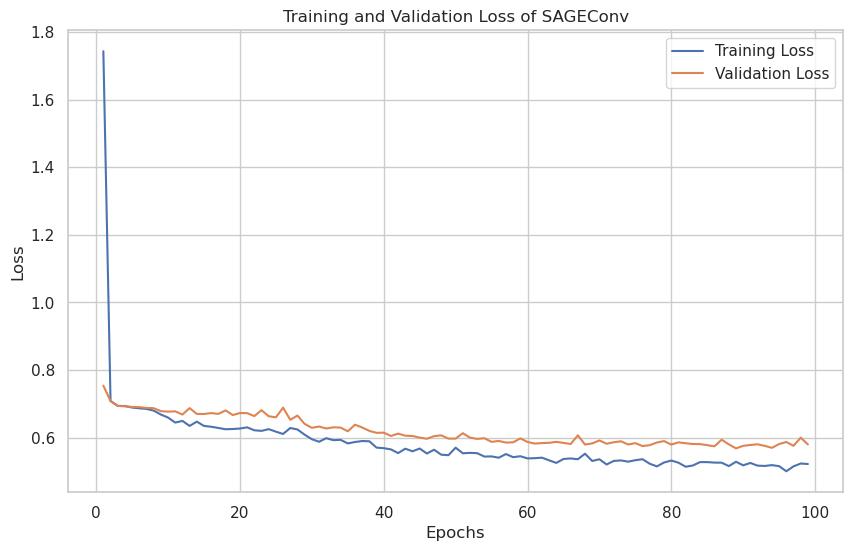

Completed training.



In [13]:
# 2. Retraining with best hyperparameters (on a larger train and val set)
print("Retraining with best hyperparameters...")
model = GraphClsSAGE(
    in_feats=74,  # This should match the input feature size of your dataset
    hidden_dim=best_hyperparams['hidden_dim'],
    aggregator_type=best_hyperparams['aggregator_type'],
    dropout_rate=best_hyperparams['dropout_rate'],
    num_cls=2  # Assuming binary classification
).to(device)

print("")

# Reset model weights and biases parameters before retraining
model.reset_parameters()

optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['lr'])
criterion = nn.CrossEntropyLoss()

early_stopping = EarlyStopping(patience_loss=10, patience_accuracy=10, 
                               verbose=False, delta_loss=0.001, 
                               delta_accuracy=0.001, path='checkpoint.pt', 
                               print_freq=5)

training_pipeline = TrainingPipeline(device)

training_pipeline.train_and_evaluate(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stopping,
    300,
    plot_curves=True)
optimal_epoch = early_stopping.best_epoch


print("Completed training.")
print("")


## Train Model with Best Hyperparameters on whole train set



In [14]:
# Before final training on the combined train and val dataset, reset the
# model weights and biases again
model.reset_parameters()

In [15]:
# 3. Final training on the combined train and val dataset with best 
# hyperparameters
print("Final training on the combined train and val dataset...")

optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['lr'])
criterion = nn.CrossEntropyLoss()

training_pipeline.train_and_evaluate(
    model,
    combined_train_loader,
    None,
    optimizer,
    criterion,
    None,
    optimal_epoch,
    plot_curves=False)

# save the model
torch.save(model.state_dict(), f'sage_model_run_{RUN_NUMBER}.pt')

print("Completed training.")
print("")


Final training on the combined train and val dataset...


Completed training.



## Evaluate the Model



Evaluating on the test set...


Test Loss: 0.5908394008874893
Accuracy: 0.720253164556962, Precision: 0.7430167597765364, Recall: 0.6734177215189874, F1-Score: 0.706507304116866, ROC-AUC: 0.7202531645569621
Completed evaluation.


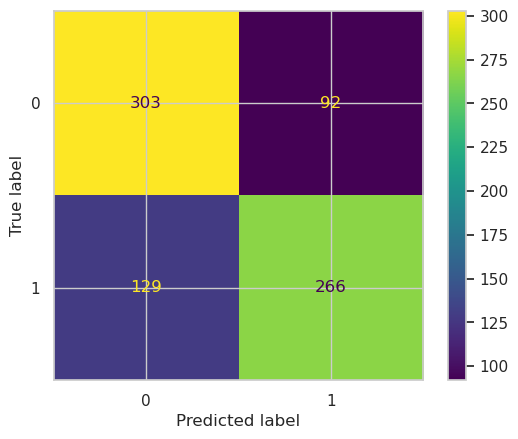

In [16]:
# Evaluation on the test set
print("Evaluating on the test set...")
training_pipeline.evaluate_on_test(model, test_loader, criterion, RUN_NUMBER)
print("Completed evaluation.")
